# Lending Club – Loan Default Probability Prediction

---

## 0. Project Overview

### Context and Business Objective

The goal of this project is to predict the **probability of loan default** for borrowers from the *Lending Club* dataset.  
Each row represents a loan issued to an individual borrower, with information available **at the time of loan origination** (e.g., loan amount, interest rate, income, credit history, employment, purpose).

Our objective is to build a **credit risk scoring model** that estimates the likelihood of default.  
In this context, a *default* means that the borrower failed to fully repay the loan (*Charged Off* or *Default*).

Predicting this probability enables investors and financial institutions to:
- Better assess credit risk before lending.
- Optimize portfolio diversification.
- Reduce expected financial loss.

This problem is formulated as a **binary classification** task:
- `1` → loan default (Charged Off or Default)  
- `0` → fully paid or currently active loans

## 1. Dataset Overview

### Data Source

The dataset comes from **Lending Club**, a peer-to-peer lending platform that connects investors with borrowers.  
The data spans loans issued between **2007 and 2018**, and contains information about:
- Borrower demographics and employment.
- Loan terms (amount, interest rate, duration).
- Credit history and payment records.
- Loan status (the target variable).

In [ ]:
import kagglehub
import os

# Download latest version. Lending Club comes from Kaggle
path = kagglehub.dataset_download("wordsforthewise/lending-club")

print("Path to dataset files:", path)

# Affiche la liste des fichiers téléchargés dans le dossier
print(os.listdir(path))

Using Colab cache for faster access to the 'lending-club' dataset.
Path to dataset files: /kaggle/input/lending-club
['rejected_2007_to_2018Q4.csv.gz', 'accepted_2007_to_2018Q4.csv.gz', 'accepted_2007_to_2018q4.csv', 'rejected_2007_to_2018q4.csv']


Taille réduite du dataset : (452140, 151)
<class 'pandas.core.frame.DataFrame'>
Index: 452140 entries, 392949 to 867240
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 524.3+ MB
None
       member_id      loan_amnt    funded_amnt  funded_amnt_inv  \
count        0.0  452134.000000  452134.000000    452134.000000   
mean         NaN   15038.632850   15033.657776     15015.775097   
std          NaN    9181.766433    9179.968213      9183.440150   
min          NaN     500.000000     500.000000         0.000000   
25%          NaN    8000.000000    8000.000000      8000.000000   
50%          NaN   12875.000000   12825.000000     12800.000000   
75%          NaN   20000.000000   20000.000000     20000.000000   
max          NaN   40000.000000   40000.000000     40000.000000   

            int_rate    installment    annual_inc            dti  \
count  452134.000000  452134.000000  4.521330e+05  451787.000000   
mean       13.089122     445.67462

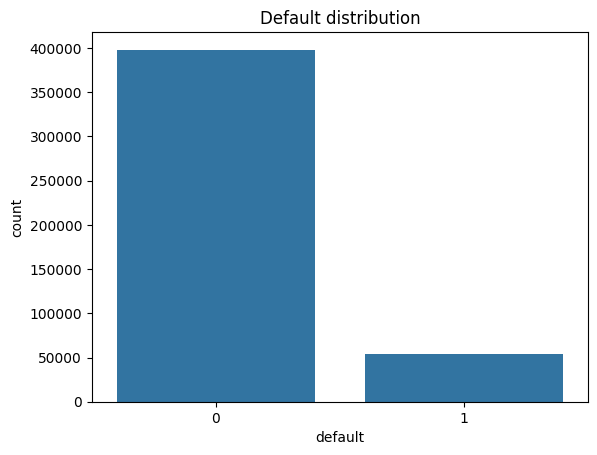

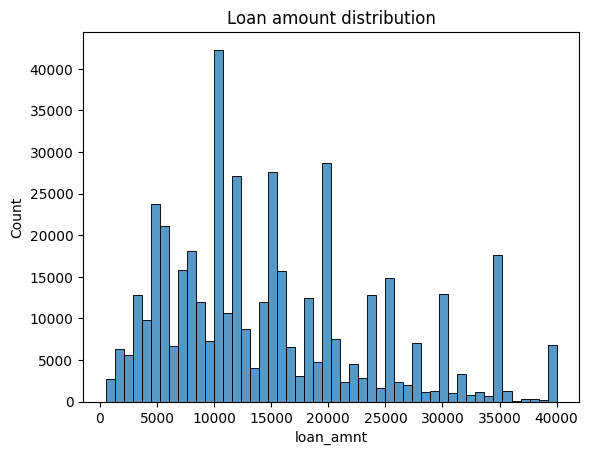

In [ ]:
# 1. Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load dataset
file_name = 'accepted_2007_to_2018Q4.csv.gz'
file_path = os.path.join(path, file_name)
df = pd.read_csv(file_path, low_memory=False)

# On ne garde que 20% des données de manière aléatoire pour économiser la RAM
df = df.sample(frac=0.2, random_state=42)
print("Taille réduite du dataset :", df.shape)
# -------------------

# 3. Basic info.
print(df.info())
print(df.describe())

# 4. Target variable.  We transform the columns which is a categorial variable in binary variable. It is obligate. 0: Borrower does not default. 1: Borrower defaults.
df['default'] = df['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Default'] else 0)
print(df['default'].value_counts(normalize=True))

# 5. Simple visualizations.
sns.countplot(x='default', data=df)
plt.title("Default distribution")
plt.show()

sns.histplot(df['loan_amnt'], bins=50)
plt.title("Loan amount distribution")
plt.show()


#We have 152 features and one target = loan_status


### Basic Structure

| Attribute | Description |
|------------|-------------|
| **Rows** | 2,260,701 loans |
| **Columns** | 152 variables (84 numeric, 24 categorical) |
| **Size** | ~1.8 GB |
| **Target variable** | `default` (1 = defaulted loan, 0 = fully paid/current) |

### Data Type Breakdown
- **Numerical features (float64)**: 113
- **Categorical features (object)**: 38
- **Imbalance**:  
  - Defaulted loans ≈ 11.9%  
  - Non-defaulted loans ≈ 88.1%  

This imbalance will need to be addressed later using either **class weights** or **resampling techniques**.

In [ ]:
# Drop columns with >50% missing values. We chosse to do that because this features represent a disptof to help the credits. They won't give information for our model(s).
missing_ratio = df.isnull().mean()
df = df.loc[:, missing_ratio <= 0.5]
print("Shape after drop:", df.shape)

#New information on the dataset : 108 entries. So it drops 44 columns.

#More informations on the dataset :

# Count of numeric vs categorical features
num_cols = df.select_dtypes(include=['number']).columns
cat_cols = df.select_dtypes(exclude=['number']).columns

print(f"Numeric variables: {len(num_cols)}")
print(f"Categorical variables: {len(cat_cols)}")

#--> As the dataset has been cleaned we can organize how we will do to predict the probability of default.
#We say that he is clean but, not totally... We have to encode, find outliers, treat the missing value of all the categorial variable for the precition model and find an optimal method to remplace all the other missing values.
#But we will do  that after.

#if we want to know the number of missing value :
print("\nRemaining missing values :", df.isnull().sum().sum()) # = 15 402 538. This is a lot. 12
print("Shape final :", df.shape)

Shape after drop: (452140, 108)
Numeric variables: 84
Categorical variables: 24

Remaining missing values : 3067406
Shape final : (452140, 108)


## 2. Methodology and Plan

The project follows a **standard supervised machine learning workflow**, aligned with the evaluation rubric provided.

### Step 1 — Data Understanding and Exploration
- Import libraries and dataset  (already done)
- Explore dataset size, structure, types  (already done)
- Analyze missing values, (already done)
- duplicates, outliers  
- Study target imbalance (`default`)  
- Perform correlation and variable quality checks  

### Step 2 — Data Preprocessing
- Handle missing values (median/mode imputation)  
- Remove irrelevant or leakage features  
- Encode categorical variables  
- Scale numerical features (StandardScaler)  
- Split dataset into train/test sets (stratified)  

### Step 3 — Baseline Model
- Train a **Logistic Regression** model  
- Evaluate with metrics: ROC-AUC, Precision, Recall, F1-score  
- Interpret model coefficients  

### Step 4 — Model Improvement and Optimization
- Address overfitting/underfitting (regularization, tuning)  
- Handle imbalance (class weights, SMOTE)  
- Test other models (Random Forest, XGBoost)
- Innovative model (exlication + implementation)
- Compare performance  

### Step 5 — Dimensionality Reduction & Decision Tree, GridSearch
- Apply **PCA** on scaled features on a copy dataset + Test performance on models
- Compare performance and explainability
- Decision Tree  
- GridSearch
- Compare performance and explainability

### Step 6 — Model Comparison and Conclusion
- Summarize model results  
- Discuss limitations and perspectives  
- Conclude on model performance and **business interpretation**

---

## 3. Deliverables

- **Jupyter Notebook (.ipynb)** with clear markdown explanations and commented code.  
- **GitHub repository** with clean structure (`data/`, `notebooks/`, `src/`, `reports/`).  
- **Final evaluation metrics** and model comparison table.  

In [ ]:
#Detection of duplicates rows. If we detect duplicates rows we remove the rows. If thre is any duplicate we do nothing. It is no use to study rows that are the same.
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove them if any
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Duplicates removed. New shape: {df.shape}")
else:
    print("No duplicate rows detected. So we do nothing")

#The program detect 0 duplicate rows. So we removed 0 rows on the dataset.

Number of duplicate rows: 0
No duplicate rows detected. So we do nothing


## Discussion : Study of the outliers, optimal method

- After some researchs on internet, there is exist a lot of method to study the outliers like the "test of chauvenet", "test of Grubbs" etc...
- Find the better method permits to have a better analyse of the outliers and it permits to take the better decision of what we will do with this outliers.

--> In our dataset, a lot of variables are right-skewed because this is typicall of the incomes, amount or rate.
    So if we detect ours outliers with the mean or the standard deviation this may be biaised by some extreme outliers.
    
--> But there is exists a method which does not depend on this parametre : Interquantile Range.
    It consists to determine a range base on the first and the third quantile. So an outliers will a be a value that is not in this range.
    ![image.png](attachment:image.png) . And k is a positive constant (on the image).

    Historically, we choose k = 1.5 because, John tukey the inventor of the boxplot used it to detect all the point that are beyond 3 standard deviation. It is reasonable because it doesn't choose a lot of points like outliers but it is quite flexible to spot anomalies in the disttibution queue.

##### Let's apply this on the most important quantitative variables and interpretable for our subject like loan_amount, annual_inc, int_rate, dti. It is useful to have a global pattern like asymetrie, dispersion, outliers proportion and the nature of extreme values. On this treatment of outliers we will study the economic sense of outliers and apply what can remedy to the extreme values. We won't apply that on all the features because we just want a robust dataset. Additionally, there is model of prediction like XGBoost, LightGBM which are not sensible to the outliers. So if we treat the outliers of the most relevant variable of our dataset and for our model that's enough. After we will apply an IQR for all the top 10 correlated variables with default. For the other variables we will do an automatic clip IQR. We recall that we will do that just the numeric variables.

![image-2.png](attachment:image-2.png)


 Feature: loan_amnt
   - Q1: 8000.00, Q3: 20000.00, IQR: 12000.00
   - Lower bound: -10000.00, Upper bound: 38000.00
   - Outliers: 7063 (1.56%)

Descriptive statistics:


,Full dataset,Without outliers
count,452134.000000,445071.000000
mean,15038.632850,14643.378079
std,9181.766433,8697.174871
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12875.000000,12500.000000
75%,20000.000000,20000.000000
max,40000.000000,38000.000000


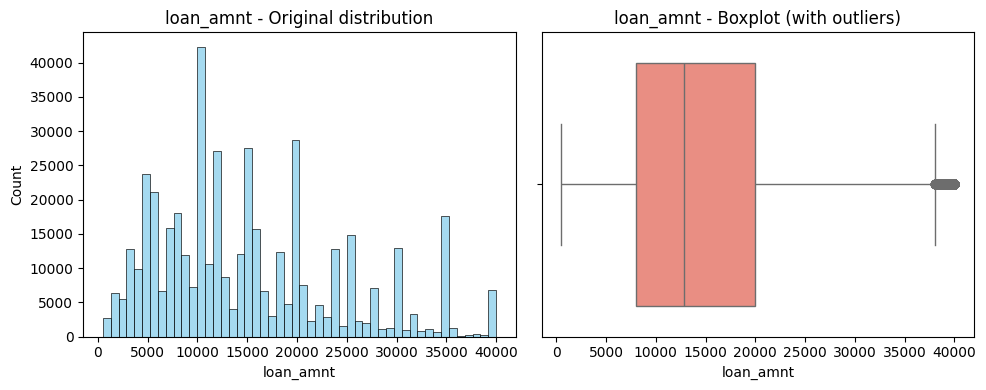


 Feature: annual_inc
   - Q1: 46000.00, Q3: 93000.00, IQR: 47000.00
   - Lower bound: -24500.00, Upper bound: 163500.00
   - Outliers: 22048 (4.88%)

Descriptive statistics:


,Full dataset,Without outliers
count,4.521330e+05,430085.000000
mean,7.791887e+04,69105.110674
std,7.536972e+04,31608.106512
min,0.000000e+00,0.000000
25%,4.600000e+04,45000.000000
50%,6.500000e+04,64000.000000
75%,9.300000e+04,88000.000000
max,1.099920e+07,163500.000000


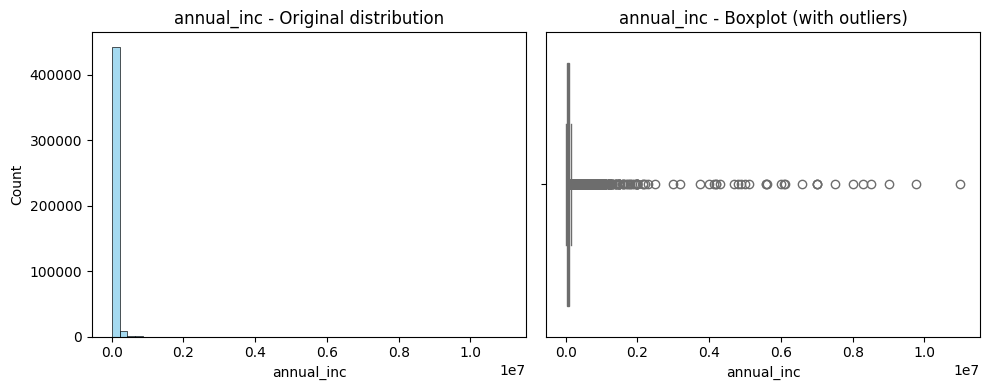


 Feature: int_rate
   - Q1: 9.49, Q3: 15.99, IQR: 6.50
   - Lower bound: -0.26, Upper bound: 25.74
   - Outliers: 8161 (1.80%)

Descriptive statistics:


,Full dataset,Without outliers
count,452134.000000,443973.000000
mean,13.089122,12.817778
std,4.832227,4.431224
min,5.310000,5.310000
25%,9.490000,9.440000
50%,12.620000,12.610000
75%,15.990000,15.610000
max,30.990000,25.690000


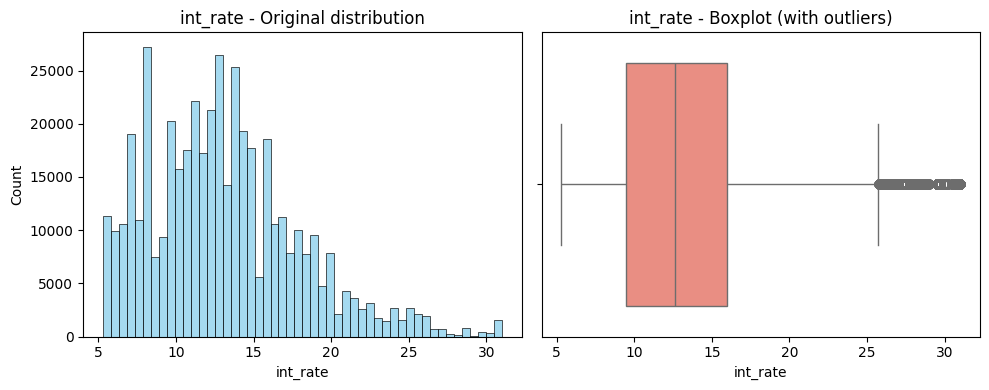


 Feature: dti
   - Q1: 11.91, Q3: 24.52, IQR: 12.61
   - Lower bound: -7.00, Upper bound: 43.44
   - Outliers: 4306 (0.95%)

Descriptive statistics:


,Full dataset,Without outliers
count,451787.000000,447481.000000
mean,18.846578,18.267520
std,14.028355,8.551972
min,-1.000000,-1.000000
25%,11.910000,11.840000
50%,17.890000,17.770000
75%,24.520000,24.300000
max,999.000000,43.430000


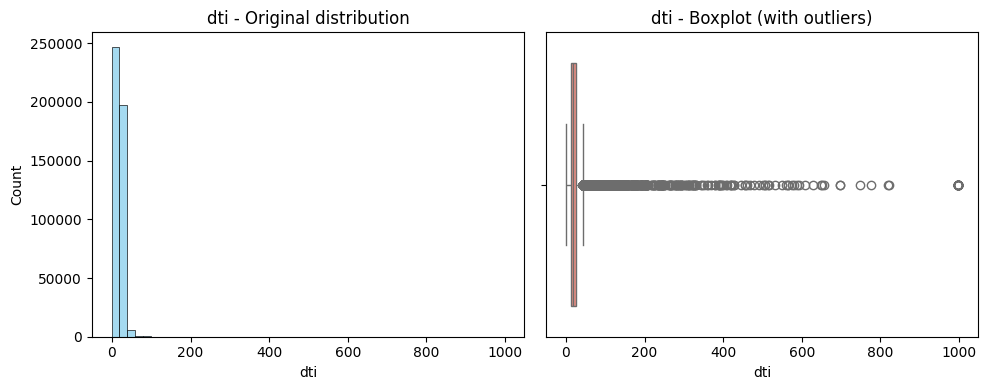

Top 10 correlated features with default:


,default
last_fico_range_high,0.601075
last_fico_range_low,0.558124
recoveries,0.521383
collection_recovery_fee,0.495549
total_rec_prncp,0.225819
out_prncp,0.211042
out_prncp_inv,0.211021
int_rate,0.199612
last_pymnt_amnt,0.180967
total_pymnt,0.140248


last_fico_range_high      -> Outliers: 5.61% (Lower=542.00, Upper=846.00)
last_fico_range_low       -> Outliers: 5.61% (Lower=538.00, Upper=842.00)
recoveries                -> Outliers: 8.24% (Lower=0.00, Upper=0.00)
collection_recovery_fee   -> Outliers: 7.86% (Lower=0.00, Upper=0.00)
total_rec_prncp           -> Outliers: 3.98% (Lower=-12123.56, Upper=28926.10)
out_prncp                 -> Outliers: 10.00% (Lower=-8598.73, Upper=14740.68)
out_prncp_inv             -> Outliers: 10.00% (Lower=-8591.83, Upper=14728.85)
int_rate                  -> Outliers: 2.16% (Lower=0.39, Upper=25.09)
last_pymnt_amnt           -> Outliers: 14.45% (Lower=-4462.02, Upper=8491.64)
total_pymnt               -> Outliers: 4.20% (Lower=-12792.74, Upper=34257.13)
Clipping applied to 71 numeric columns.


In [ ]:
#Study of outliers
import numpy as np

def outlier_summary_principalfeatures(data, col):
    """Compute outlier thresholds and return descriptive insights."""
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Flag outliers
    outliers = data[(data[col] < lower) | (data[col] > upper)]
    proportion = len(outliers) / len(data) * 100

    print(f"\n Feature: {col}")
    print(f"   - Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"   - Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")
    print(f"   - Outliers: {len(outliers)} ({proportion:.2f}%)")

    # Compare descriptive stats
    print("\nDescriptive statistics:")
    display(pd.DataFrame({
        "Full dataset": data[col].describe(),
        "Without outliers": data[(data[col] >= lower) & (data[col] <= upper)][col].describe()
    }))

    # Visualize the distribution
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(data[col], bins=50, ax=axes[0], color='skyblue')
    axes[0].set_title(f"{col} - Original distribution")

    sns.boxplot(x=data[col], ax=axes[1], color='salmon')
    axes[1].set_title(f"{col} - Boxplot (with outliers)")
    plt.tight_layout()
    plt.show()

# Analyse for main numerical features
for col in ['loan_amnt', 'annual_inc', 'int_rate', 'dti']:
    if col in df.columns:
        outlier_summary_principalfeatures(df, col)




#Feature loan_amnt (montant du prêt):
# --> The majority of the loan amount are around 10-20k€, and some are at 35-40k€. Economically, this is possible that there's loan at this amount. So we keep this extremes.

#Feature annual_inc (revenue annuel):
# --> This distribution is a lot right-skewed. The majority of the income are inferior at 150k€. But we remark that there is an extreme value at 1.0e8. It is impossible for an income.
# The high threshold is at maximum 200k€. So, we transform with a logarithm (log1p) before modeling to reduce asymmetry :
df['annual_inc_log'] = np.log1p(df['annual_inc'])

#Feature int_rate (taux d'intérêt):
# --> There is an asymetric distribution to the right. The outliers > 25% represent very risky investors (we can affirm that after some research)

#Feature dti (ratio dette/revenu) :
#--> There's value > 100. This is impossible economically because it means that the borrowers have a loan superior to his salary.
# So we will remove all the lines where dti > 100 :
df = df[df["dti"].between(0,100, inclusive="both")]

#-------------------Top 10 correlated value------

#
#Correlationof numeric variables with the target
corr_with_target = df.select_dtypes(include=np.number).corr()['default'].abs().sort_values(ascending=False)

top10_corr = corr_with_target.head(11)
print("Top 10 correlated features with default:")
display(top10_corr[1:])  # remove of default

for col in top10_corr[1:].index:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.4 * IQR, Q3 + 1.4 * IQR #There we choose k = 1.4 to be more conservative because we won't treat the economic sense of each variables.
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    pct = outliers / len(df) * 100
    print(f"{col:25s} -> Outliers: {pct:.2f}% (Lower={lower:.2f}, Upper={upper:.2f})")

#---Clip other outliers on other variable
def clip_outliers(series):
    """Clip outliers based on IQR """
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.2 * IQR, Q3 + 1.2 * IQR #k=1.2 to be more conservative because it will treat a lot of information and we don't to lose a lot as we don't treat them manually.
    return np.clip(series, lower, upper)

#VAriables to exclude of the clipping : variables too sensible (top10 + aleready treated)
exclude_cols = ['loan_amnt', 'annual_inc', 'int_rate', 'dti'] + list(top10_corr.index)

# Apply the clipping for the rest
numeric_cols = [col for col in df.select_dtypes(include=np.number).columns if col not in exclude_cols]

df[numeric_cols] = df[numeric_cols].apply(clip_outliers)
print(f"Clipping applied to {len(numeric_cols)} numeric columns.")




### Target Variable – Class Imbalance Analysis

Default class distribution:
default
0    397313
1     53955
Name: count, dtype: int64

Percentage distribution:
default
0    88.04
1    11.96
Name: proportion, dtype: float64


/tmp/ipython-input-203683560.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")


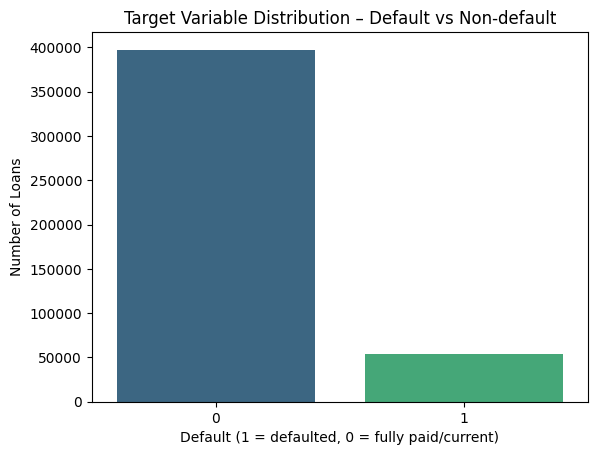

"The target variable default is highly imbalanced, with approximately 88% of non-defaulted loans and 12% of defaulted ones. If we corrige nothing the models will predict 0 almost all the time.\nThis imbalance reflects a realistic financial scenario, as most borrowers repay their loans successfully.\nHowever, it poses a challenge for machine learning algorithms, which may become biased toward the majority class.\nConsequently, evaluation metrics such as accuracy will not be reliable.\nTo address this, class balancing techniques (e.g., class_weight='balanced', SMOTE oversampling) will be applied during model training."

In [ ]:
# Check class distribution
target_counts = df['default'].value_counts()
target_ratio = df['default'].value_counts(normalize=True) * 100

print("Default class distribution:")
print(target_counts)
print("\nPercentage distribution:")
print(target_ratio.round(2))

# Visualize class imbalance
sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
plt.title("Target Variable Distribution – Default vs Non-default")
plt.xlabel("Default (1 = defaulted, 0 = fully paid/current)")
plt.ylabel("Number of Loans")
plt.show()

'''The target variable default is highly imbalanced, with approximately 88% of non-defaulted loans and 12% of defaulted ones. If we corrige nothing the models will predict 0 almost all the time.
This imbalance reflects a realistic financial scenario, as most borrowers repay their loans successfully.
However, it poses a challenge for machine learning algorithms, which may become biased toward the majority class.
Consequently, evaluation metrics such as accuracy will not be reliable.
To address this, class balancing techniques (e.g., class_weight='balanced', SMOTE oversampling) will be applied during model training.'''

### Correlation & Variable Quality Checks

- There, we want to measure the strength and the nature between the variables, notably between the features and the target. It will permits to us to know what variable influence the risk of default and what variable are not useless.
- So, we will see what are the variables which are moving together, what are the variable are correlated to default and detect what are the features very correlated (if they are too correlated they give the sale information --> we will remove one them in the model).

--> We only take the numerical variables for this first correlation. The categories will be integrated later (after encoding), in the Feature Selection phase.
--> We will just identify the relevant numerical variables. Understand the principal correlation.
Identify groups of similar variables.
Effectively, it can take a lot of time to study all the correlations and also it can give result that aren't visually exploitable.

- This is just for informational purposes.

# STEP 2 : DATA PREPROCESSING

### Handle missing values (median/mode imputation)

- This is an important step because we will remplace all the missing value on our dataset based on optimal methid for type of variable.

- But, as we have a lot of features we have to construct a method which the most optimal to handle missing values. We have 109 features so it can be very long to adapt our treatment of missing value. What we propose is first of all to study in depth our features and the number of missing value by features.

- First of all, we have apply a manual treatment on value which have a lot of missing values (>100 000). We could'nt apply a generic method of treatment because we could lose a lot of informations by doing this.
- Secondly, we apply a method defines on this image. It will be a method in the program :

![image.png](attachment:image.png)

- We are doing this because, after some research on internet, we have understand that they are the most adapted for each type of variable.
    - On a continue numeric serie, we prefer to remplace the NaN by the median because this is robust to the outliers, preserve the distribution and consistent economically.
    - On discrete numeric serie, we prefer to remplace by the rounded median because this is consistent with entire distribution.
    - On a categorial serie, we remplace by the mode because this the most adaptably method for the dominant method.
    - And for the post default features we delete them because this variables don't have to be used in the prediction. They can perturb her.

In [ ]:
# Compute missing values (absolute and relative)
missing_summary = (
    df.isnull()
    .sum()
    .to_frame("missing_count")
    .assign(
        missing_ratio=lambda x: (x["missing_count"] / len(df) * 100).round(2),
        dtype=df.dtypes
    )
    .query("missing_count > 0")
    .sort_values("missing_ratio", ascending=False)
)

# Display summary
print(f"Total columns with missing values: {len(missing_summary)}, (before there was 66 columns)")
display(missing_summary) #After the teartment, the sheet will be empty beacause there will be no more missing value :/.

print(df.columns)

# --> We can remarks that there is a lot of missing values. It may be due to the number of data (> 2 000 000) and the number of features (109).
# First of all, we can study all the variables in the dataset and determine what variable won't be used in the prediction of the model. This is a manual work using the excel to have a better comprehension of all the columns and groups of columns.
# We remarks that there is variable which serve to identify the borrowers. This is not useful int the prediction. So we can remove them.
cols_identify = ['id', 'member_id', 'url', 'desc', 'title', 'zip_code', 'addr_state']
df.drop(columns=cols_identify, inplace=True, errors='ignore')
# We can remarks that there is variables that are determine after that the borrowers is lacking. So they won't serve also for our dataset.
cols_after_default = ['recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'debt_settlement_flag', 'next_pymnt_d']
cols_after_default_new = [
    col for col in df.columns
    if any(prefix in col for prefix in [
        'settlement', 'hardship', 'recoveries',
        'collection_recovery_fee', 'last_pymnt', 'next_pymnt', 'debt_settlement'
    ])
]
df.drop(columns=cols_after_default, inplace=True, errors='ignore')
#Display the number of missing after remove all this variables :
print(f"Remaining columns: {df.shape[1]}")
missing_summary = df.isnull().sum().to_frame("missing_count")
missing_summary["missing_ratio"] = (missing_summary["missing_count"] / len(df) * 100).round(2)

print(missing_summary[missing_summary["missing_count"] > 0].sort_values("missing_ratio", ascending=False).head(66))

#Now we remarks that there is a features which has 1067810 missing values. This is a lot. il_util is a variable which measure if a borrowers already has a tinstallment loans (credit like student or car)
#This is a ratio between the total current balances on installment loans and the total limits of credit on this loans.
#This is interpretable economically. So we wiil keep them. And if there is nothing, this is because the loans is not an installment loans. So, if we remplace all the missing values by zero it won"t have a big effect on the dataset (0=inconnu).
df['il_util'] = df['il_util'].fillna(0)

#We have the same problem with mths_since_rcnt_il = months since most recent installment loan. This is the number of months since the last installment loans.
#So it means that we will this is a variable which can be used to create a profil of risk. And if we remplace Nan by zero it won't change economically because zero means no installment loans.
df["mths_since_rcnt_il"] = df["mths_since_rcnt_il"].fillna(0)

#all_util is the ratio between the amount of the loans used by the borrowers on the amount total of the loan. It is usefull to establish a risk profile. If there is no data this is because there is no a use of the loans.
#So we will remplace by zero, it reflects well the economic reality and won't change a lot the statistics.
df['all_util'] = df['all_util'].fillna(0)

#max_bal_bc	is the maximum balance due on bank credit cards. If there is Nan, the borrowers don't use credit card in his loan. So, it will be useful to establish a risk profile.
#We remplace by zero if there is use of credit card.
df['max_bal_bc'] = df['max_bal_bc'].fillna(0)

#open_il_12m is the same than mths_since_rcnt_il but on period of 12 months. This is also a profile of risK.
#We remplace by zero all the NaN:
df["open_il_12m"] = df["open_il_12m"].fillna(0)

#open_rv_12m is the number of revolving trades opened in 12 months. This is the number of new opening credit cards in 12 months. If there is Nan, it means that the borrowers don't use Credit Cards.
#It will be used to estblish a profile of risk. 0 in 12 months means a profile with no risk.
df['open_rv_12m'] = df['open_rv_12m'].fillna(0)

#open_il_24m = Number of installment accounts opened in past 24 months. It will establish a profile of risk. 0 = any loans open in the 24 months.
df['open_il_24m'] = df['open_il_24m'].fillna(0)

#total_bal_il = Total current balance on all installment accounts. Total sum of outstanding balances on all installment loans. Use for a profile of risk. 0 = no loans for this borrowers so 0 to repay at the bank.
#We can remplace by zero:
df['total_bal_il'] = df['total_bal_il'].fillna(0)

#open_acc_6m = Number of accounts opened in past 6 months. Use for a profile of risk. 0 = any open account in the last 6 months.
df['open_acc_6m'] = df['open_acc_6m'].fillna(0)

#inq_last_12m = Number of credit inquiries in the last 12 months. 0 = no credit inquiries in the last 12 months. It is usefull for a profile of risk : >= 6 risky profile.
df['inq_last_12m'] = df['inq_last_12m'].fillna(0)

#open_act_il = Number of currently active installment loans. If the borrowers doesn't have installment loans --> Nan. We will remplace missing values by zero:
df['open_act_il'] = df['open_act_il'].fillna(0)

#total_cu_tl= Number of credit union accounts (american bank). This is not useful for our problem because it says "where" the borrowers is doing his loan but not how he repay it.
#Additionally, we remarks that df[['total_cu_tl', 'default']].corr() ~ 0,0006 = Weak correlation. We remove them.
df.drop(columns=['total_cu_tl'], inplace=True, errors='ignore')

#inq_fi = Number of personal finance inquiries. No request = no survey -> Structural NaN. We remplace NaN by zero. It more reflects the reality.
df['inq_fi'] = df['inq_fi'].fillna(0)

#open_rv_24m = Number of revolving trades opened in the past 24 months. This is the same than open_rv_12m but on a different time scale.
# Their correlation is at 0.78. But economically they means the same things. We decide to keep the both of them because they capture information on different time scale.
#open_rv_12m ise recent and open_rv_24m is more structural.
df['open_rv_24m'] = df['open_rv_24m'].fillna(0) #Like for open_rv_12m

#mths_since_recent_inq = Months since most recent inquiry. 0 = no inquiries. Replace by zero :
df["mths_since_recent_inq"] = df["mths_since_recent_inq"].fillna(0)

#emp_title = Employment title (free text). Why Nan ? Some do not fill in the field (self-employed, retirees, etc.). We propose to to remplace the Nan by "unknown"
df['emp_title'] = df['emp_title'].fillna("Unknown")

#num_tl_120dpd_2m = Number of accounts 120+ days past due in the past 2 months. Number of accounts with overdue payments > 120 days over the last 2 months.
#Nan means no overdue payment over the last 2 months.
df['num_tl_120dpd_2m'] = df['num_tl_120dpd_2m'].fillna(0)

#emp_length = Employment length (years). Nan means without employ or newly employed. We propose to replace with "unknown"(then encode afterwards).
df['emp_length'] = df['emp_length'].fillna("Unknown")

#mo_sin_old_il_acct = Months since oldest installment account opened. Nan means no installment loans for this person. Replace by zero is the better solution:
df['mo_sin_old_il_acct'] = df['mo_sin_old_il_acct'].fillna(0)
print("Number of missing value after treatment :", df.isnull().sum().sum())

#We have treat manually all the columns with missing values. It was important they had a sense economically so we could'nt apply a generic method because it could change the sense of the informatino that they bring. Like that we have keep a maximum of original information.
#They had more than 100 000 missing values. Now he is staying variables with a maximum of 75 892 missing value. If we treat them generically with optimal method we won't lose a lot of information  because there is 75000/2000000 =3.75% de missing values. Even if the method makes lose information it won't significant.
#At the beggining there was 66 columns with missing values and more than 10 000 000 missing values in total. Now there 42 colomns with missing values and ~1 000 000 missing values.
#We have treat all the columns with a lot of missing values.
#Let's do this in the next cells to make it more readable.

Total columns with missing values: 68, (before there was 66 columns)


,missing_count,missing_ratio,dtype
il_util,212905,47.18,float64
mths_since_rcnt_il,181215,40.16,float64
all_util,172639,38.26,float64
open_il_12m,172598,38.25,float64
max_bal_bc,172598,38.25,float64
...,...,...,...
open_acc,3,0.00,float64
earliest_cr_line,3,0.00,object
delinq_amnt,3,0.00,float64
tax_liens,16,0.00,float64


Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title',
       ...
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag', 'disbursement_method',
       'debt_settlement_flag', 'default', 'annual_inc_log'],
      dtype='object', length=109)
Remaining columns: 100
                    missing_count  missing_ratio
il_util                    212905          47.18
mths_since_rcnt_il         181215          40.16
all_util                   172639          38.26
open_rv_24m                172598          38.25
max_bal_bc                 172598          38.25
...                           ...            ...
inq_last_6mths                  3           0.00
delinq_2yrs                     3           0.00
delinq_amnt                     3           0.00
tax_liens                      16           0.00
annual_inc_log                  1       

In [ ]:
# ration of Nan by columns
missing_ratio = df.isnull().mean() * 100

# Type
types = df.dtypes

missing_table = pd.DataFrame({
    'Type': types,
    'Missing (%)': missing_ratio
}).sort_values('Missing (%)', ascending=False)

display(missing_table.head(30))

threshold = 45
cols_to_drop = missing_table[missing_table['Missing (%)'] > threshold].index
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print(f"{len(cols_to_drop)} removes columns (>45% NaN)")

# continune columns (float64)
continuous_cols = [col for col in df.select_dtypes(include=['float64']).columns if df[col].nunique() > 10]

for col in continuous_cols:
    nan_ratio = df[col].isnull().mean() * 100
    if 0 < nan_ratio <= 5:
        df[col] = df[col].fillna(df[col].median())
    elif 5 < nan_ratio <= 30:
        # If the distribution is very skewed: we can log-transform before the median.
        df[col] = df[col].fillna(df[col].median())
    elif 30 < nan_ratio <= 45:
        # check correlation with target
        corr = df[col].corr(df['default'])
        if abs(corr) < 0.05:  # little correlated
            df.drop(columns=[col], inplace=True, errors='ignore')
        else:
            df[col] = df[col].fillna(df[col].median())

# Discrete columns (few unique values)
discrete_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if df[col].nunique() <= 10]

for col in discrete_cols:
    nan_ratio = df[col].isnull().mean() * 100
    if 0 < nan_ratio <= 40:
        df[col] = df[col].fillna(round(df[col].median()))
    elif nan_ratio > 40:

        # check is the variable is useful, else remove
        corr = df[col].corr(df['default'])
        if abs(corr) < 0.05:
            df.drop(columns=[col], inplace=True, errors='ignore')

categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    nan_ratio = df[col].isnull().mean() * 100
    if 0 < nan_ratio <= 5:
        df[col] = df[col].fillna(df[col].mode()[0])
    elif 5 < nan_ratio <= 30:
        df[col] = df[col].fillna("Unknown")
    elif nan_ratio > 30:
        df.drop(columns=[col], inplace=True, errors='ignore')

#Final verification :
print("Display the missing values after imputation:", df.isnull().sum().sum())
print("final dimension :", df.shape)

#--> After imputation we have, 85 columns and 2256394 rows. And of course 0 missing values.
#All the missing value have been treated. We can passe to the next session.

,Type,Missing (%)
bc_util,float64,3.337485
percent_bc_gt_75,float64,3.304245
bc_open_to_buy,float64,3.287182
mths_since_recent_bc,float64,3.225135
pct_tl_nvr_dlq,float64,3.093062
avg_cur_bal,float64,3.088852
mo_sin_old_rev_tl_op,float64,3.086414
mo_sin_rcnt_rev_tl_op,float64,3.086414
num_rev_accts,float64,3.086414
num_actv_bc_tl,float64,3.086193


0 removes columns (>45% NaN)
Display the missing values after imputation: 0
final dimension : (451268, 99)


### Encode categorical variables

['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'earliest_cr_line', 'initial_list_status',
       'last_credit_pull_d', 'application_type', 'hardship_flag',
       'disbursement_method'] is all our categorical variable.
- We will encode each variables with the most appropriate method as regards their type and economic significance. We will also determinate if we encode the variable at this step or if we encode them just before each regression. Indeed, it is better to don't econde some variables because their encodage can really perturb the model.

    - term : we encode her now due to his stable structure. She's ordinal (36<60 mois). We will use a OrdinalEncoder (36 -> 0, 60 -> 1) because it conserve the order (longer duration means more risky).
    - grade and sub_grade : we encode them nowdue to their stable structure. She's ordinal (A < B <... < G). We will use a OrdinalEncoder (A→1 ... G→7) because this is an internal score and impose an economical order is good.
    - emp_length : we encode them now due to his stable structure. She's ordinal ("<1", "1", ..., "10+"). We will normalize the text and apply a mpping like "< 1 year"→0, "10+ years”→10. Higher seniority = stability --> relevant order
        - This four variables will represent the family of ordinal and will be encode with OrdinalEncoder.
    
    - issue_d (date d'émission), earliest_cr_line (première ligne de crédit), last_credit_pull_d (dernière vérification) : we encode her now due to their stable structure and their direct economic sense. They will all be transform in years with a manual method in the code and not a method which comes from a python library.
        - They belong to the temporel family. They are maturities.
    
    - home_ownership, verification_status : won't be encode now because it is preferable to have to encode with One-Hot for linear models and it is preferable to encode with LabelEncoder if we use tree model. This is preferable to differ because there's no order and OneHot evite artificial order for linear model. They are nominal (home_ownership :OWN/RENT/MORTGAGE/OTHER/NONE), (verification_status: Verified/Not Verified/Source Verified) but we won't encode them now.
    - purpose : the same than above because if we encode with One-Hot it can create a lot of new columns because there is a lot of modality. If linear model : One-hOt, if tree model : LabelEncoding, if advanced model : Targetencoding. Sh'es nominal
    - application_type, disbursement_method, initial_list_status : we encode them now because they're quasi-binaire or binaire (application_type : Individual/Joint) and (disbursement_method: Cash/DirectPay) and (initial_list_status : 'W'/'F'). We will encode them with a binary mapping like the target. They belong to the nominal family but we will encode them now. They are quasi-binary

    - pymnt_plan : encode now. She's binary (‘y’/‘n’). We will encode with a mapping. Binary family
    - hardship_flag : indicates whether the client has opted into a financial hardship plan ("hardship plan"). "Y" if the loan has been modified to help the borrowers else "N". So this flag is create uniquely after that the client has difficulty to repay the loan. This is not an information disponible before the loan. There is a risk of leakage because we have an information after the creation of the loan. It is an information of default. it is a direct leaks towards the target. We will have to verify the correlation ith default. If correlation > 0.5 and if there is a weak presence of "Y" this is an indicator post-default and we will have to remove them.

    - emp_title : we will remove her because this is just text with a big cardinality. There is a lot of modality.
    - loan_status = target. To remove.

So we can differenciate two types : the features to encode now and the features to encode before to predict the model. In this two type we can differenciate some family :
        - FamilyOrdinal_OrdinalEncoder = ['term', 'grade', 'emp_length']
        - Family_Maturity = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d']
        - Family_EncodeAfter_Nominal = ['home_ownership', 'verification_status', 'purpose']
        - Family_EncodeNow_Nominal_quasibinary = ['application_type', 'disbursement_method', 'initial_list_status']
        - Family_EncodeNow_Binary = ['pymnt_plan']
        - Family_ToRemove = ['emp_Title', 'loan_status']


In [ ]:
#List of alll categorical variables
print(categorical_cols)

#print(df['hardship_flag'].value_counts(dropna=False))

#correlation of hardship-flag with default
corr = df['hardship_flag'].map({'Y': 1, 'N': 0}).corr(df['default'])
print("Corrélation hardship_flag / default :", corr) #--> It does not cause an information leak, but its explanatory power is nil. We remove to alleviate the dataset.
df.drop(columns=['hardship_flag'], inplace=True, errors='ignore')

#Before to begin, we want to verify the correlation between grade and sub_grade which could give the same information to default. Indeed, they both note the profil of risk of the borrowers.
grade_order = list("ABCDEFG")
grade_map = {g: i+1 for i, g in enumerate(grade_order)}
df['grade_num'] = df['grade'].map(grade_map)

sub_order = [g+str(i) for g in grade_order for i in range(1,6)]
sub_map = {sg: i+1 for i, sg in enumerate(sub_order)}
df['sub_grade_num'] = df['sub_grade'].map(sub_map)

corr_grade_sub = df['grade_num'].corr(df['sub_grade_num'])
print(f"Corrélation grade / sub_grade : {corr_grade_sub:.3f}") #There is a big correlation. They give the same information. It can be redudant for the model.
#We chosse to to remove sub_grade because grade have less modality. It simplify.
df.drop(columns=['sub_grade', 'grade_num', 'sub_grade_num'], inplace=True, errors='ignore')

#Creation of the family to Encode. the objective is to create a Pipeline of Encodage
FamilyOrdinal_OrdinalEncoder = ['term', 'grade', 'emp_length']
Family_Maturity = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d']
Family_EncodeAfter_Nominal = ['home_ownership', 'verification_status', 'purpose']
Family_EncodeNow_Nominal_quasibinary = ['application_type', 'disbursement_method', 'initial_list_status']
Family_EncodeNow_Binary = ['pymnt_plan']
Family_ToRemove = ['emp_title', 'loan_status']

#1. Encode Family Maturity (temporel):
#We encode just the of them because we have to keep the original value of issue_d to do the split temporel (we need them after). We realized that we had them in a later stage, so we differentiated between these two cases.
for col in ['earliest_cr_line', 'last_credit_pull_d']:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = (pd.Timestamp.now() - df[col]).dt.days / 365

df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce') #Conversion in datatime for the temporel split
df['issue_d_years'] = (pd.Timestamp.now() - df['issue_d']).dt.days / 365.0 #Conversion in years

#2. Encode Ordinal Family:
# term : "36 months"/"60 months" -> 0/1
if 'term' in df.columns:
    df['term'] = df['term'].astype(str).str.extract(r'(\d+)').astype(float)
    df['term'] = (df['term'] > 36).astype(int)  # 36->0, 60->1

if 'grade' in df.columns:
    grade_order = list("ABCDEFG") #define the economic order
    grade_map = {g: i + 1 for i, g in enumerate(grade_order)}
    df['grade'] = df['grade'].map(grade_map)

# emp_length : normalisation towards years
if 'emp_length' in df.columns:
    s = df['emp_length'].astype(str).str.lower().str.strip()
    # uniformisation simple
    s = (s.str.replace(r'[^0-9+<]', '', regex=True)
           .replace({'10+':'10', '<1':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5',
                     '6':'6', '7':'7', '8':'8', '9':'9'}))
    df['emp_length'] = pd.to_numeric(s, errors='coerce')



#3. Encode quasi-binary family; application_type (Individual/Joint), disbursement_method (Cash/DirectPay), initial_list_status (W/F)
if 'application_type' in df.columns:
    df['application_type'] = df['application_type'].astype(str).str.lower()
    df['application_type'] = df['application_type'].map({'individual':0, 'joint':1}).fillna(0).astype(int)

if 'disbursement_method' in df.columns:
    df['disbursement_method'] = df['disbursement_method'].astype(str).str.lower()
    df['disbursement_method'] = df['disbursement_method'].map({'cash':0, 'directpay':1}).fillna(0).astype(int)

if 'initial_list_status' in df.columns:
    # W/F -> 0/1
    df['initial_list_status'] = df['initial_list_status'].astype(str).str.lower().str.strip()
    df['initial_list_status'] = df['initial_list_status'].map({'w':0, 'f':1}).fillna(0).astype(int)


#4. Encode binary family:
if 'pymnt_plan' in df.columns:
    df['pymnt_plan'] = df['pymnt_plan'].astype(str).str.lower().str.strip()
    df['pymnt_plan'] = df['pymnt_plan'].map({'n':0, 'y':1}).fillna(0).astype(int)

#5. Remove elements to remove
if Family_ToRemove:
    df.drop(columns=Family_ToRemove, inplace=True, errors='ignore')

# Prepare EncodeAfer Nominal Family
for col in Family_EncodeAfter_Nominal:
    if col in df.columns:
        # Merging of rare categories (<1%) to stabilize future OHE
        freqs = df[col].value_counts(normalize=True)
        rares = freqs[freqs < 0.01].index
        df[col] = df[col].astype(str)
        df.loc[df[col].isin(rares), col] = 'OTHER'
        df[col] = df[col].astype('category')

print("\neffectuate Encodage for :",
      [c for c in ['term','grade','emp_length','issue_d','earliest_cr_line','last_credit_pull_d',
                   'application_type','disbursement_method','initial_list_status','pymnt_plan'] if c in df.columns])

print("\nTo Encode Later (with different model) :", Family_EncodeAfter_Nominal)


Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'earliest_cr_line', 'initial_list_status',
       'last_credit_pull_d', 'application_type', 'hardship_flag',
       'disbursement_method'],
      dtype='object')
Corrélation hardship_flag / default : -0.006874760585510071
Corrélation grade / sub_grade : 0.974


/tmp/ipython-input-1311268441.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipython-input-1311268441.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipython-input-1311268441.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce') #Conversion in datatime for the temporel split



effectuate Encodage for : ['term', 'grade', 'emp_length', 'issue_d', 'earliest_cr_line', 'last_credit_pull_d', 'application_type', 'disbursement_method', 'initial_list_status', 'pymnt_plan']

To Encode Later (with different model) : ['home_ownership', 'verification_status', 'purpose']


In [ ]:
for c in ['term','grade','emp_length','issue_d','issue_d_years','earliest_cr_line','last_credit_pull_d',
                   'application_type','disbursement_method','initial_list_status','pymnt_plan']:
        print(f"\n{c} : ", df[c].head(5))


term :  392949     1
1273506    0
324024     0
2066630    0
477199     1
Name: term, dtype: int64

grade :  392949     2
1273506    3
324024     1
2066630    2
477199     5
Name: grade, dtype: int64

emp_length :  392949     10.0
1273506     NaN
324024      4.0
2066630    10.0
477199     10.0
Name: emp_length, dtype: float64

issue_d :  392949    2015-02-01
1273506   2014-05-01
324024    2015-04-01
2066630   2017-12-01
477199    2018-02-01
Name: issue_d, dtype: datetime64[ns]

issue_d_years :  392949     10.843836
1273506    11.600000
324024     10.682192
2066630     8.010959
477199      7.841096
Name: issue_d_years, dtype: float64

earliest_cr_line :  392949     44.202740
1273506    24.690411
324024     22.271233
2066630    20.520548
477199     26.443836
Name: earliest_cr_line, dtype: float64

last_credit_pull_d :  392949     6.764384
1273506    8.345205
324024     6.841096
2066630    7.178082
477199     6.764384
Name: last_credit_pull_d, dtype: float64

application_type :  392949   

#### So now all the categorical variables are encoded (not all because we will adapt for certain variables). We will can pass to the next step :

### 1.Scale numerical features (StandardScaler)
### 2.Split dataset into train/test sets (stratified)  

- To do this we create Pipeline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# 1. Separate X / y
y = df['default'].astype(int)
X = df.drop(columns=['default']).copy()

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['category']).columns.tolist()

# ===== Préprocesseur robuste
preprocess_logit = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),          # gère tous les NaN numériques
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),   # gère NaN catégoriels
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_cols)
    ],
    remainder='drop'
)

# ===== Modèle
logit_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
)

pipe_logit = Pipeline([
    ('preprocess', preprocess_logit),
    ('model', logit_model)
])

# ===== Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# (debug optionnel) vérifier NaN juste avant fit
# na_cols = X_train.columns[X_train.isna().any()]
# print("NaN cols:", list(na_cols))

pipe_logit.fit(X_train, y_train)
pred_proba = pipe_logit.predict_proba(X_test)[:, 1]
pred_label = (pred_proba >= 0.5).astype(int)

print("ROC-AUC (logit):", roc_auc_score(y_test, pred_proba))
print(classification_report(y_test, pred_label, digits=3))

ROC-AUC (logit): 0.9995546354790694
              precision    recall  f1-score   support

           0      0.999     0.999     0.999     79463
           1      0.995     0.995     0.995     10791

    accuracy                          0.999     90254
   macro avg      0.997     0.997     0.997     90254
weighted avg      0.999     0.999     0.999     90254



### Discussion : INterpretation of this results

- We have really score, too really good score... This is not normal ROC-AUC = 0.997. This is a lot.
- We certainly have post-default variables that disrupt our prediction and therefore predict our model too well. We search features that are before the issue date else it will give information that we normally don't have when we want to predict a probability of default.
- 1. To verify this, we can split randomly because our can learn with loan of 2018 to predict 2017 (TimeSeriesSplit)
- 2. We can stop the issue_date on 2017 and test on 2018.

It can be also due to the high number of variables which give excellent results for linear model. It surrentraine the model.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

# Ensure that the data is sorted chronologically
df = df.sort_values('issue_d')

# Separe X and Y
X = df.drop(columns=['default'])
y = df['default']

# Create the time splitter (e.g., 5 folds)
tscv = TimeSeriesSplit(n_splits=5)

# Launch cross-validation on your entire pipeline
auc_scores = cross_val_score(
    pipe_logit,  # ton pipeline complet
    X, y,
    cv=tscv,
    scoring=make_scorer(roc_auc_score)
)

print(f"ROC-AUC moyenne temporelle : {auc_scores.mean():.4f}")
print(f"Détails par fold : {auc_scores}")

#--> This results confirm that the model don't use leak variables.



ROC-AUC moyenne temporelle : 0.9976
Détails par fold : [0.99505475 0.99779181 0.99885274 0.99832466 0.99811358]


In [ ]:
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')
df = df.dropna(subset=['issue_d'])
df['issue_year'] = df['issue_d'].dt.year

# issue_d_years : on ne veut plus de "now()", on met une constante neutre
df['issue_d_years'] = 0.0

# Les âges (si tu en utilises) sont référencés à la date d’émission, pas à maintenant
for col in ['earliest_cr_line', 'last_credit_pull_d']:
    if col in df.columns:
        d = pd.to_datetime(df[col], errors='coerce')
        df[col] = ((df['issue_d'] - d).dt.days / 365.0).clip(lower=0)


# 1. tri and time plit
df = df.sort_values('issue_d')
train = df[df['issue_year'] <= 2017]
test  = df[df['issue_year'] == 2018]
print("Train/Test:", train.shape, test.shape)

# 2. We exclude time data
drop_cols = ['default', 'issue_d', 'issue_year']  # we keep issue_d_years (numeric feature)
X_train = train.drop(columns=drop_cols, errors='ignore').copy()
y_train = train['default'].astype(int)
X_test  = test.drop(columns=drop_cols, errors='ignore').copy()
y_test  = test['default'].astype(int)

# 3) reconstruct column lists after split (very important)
#convert object to category for OHE
obj_cols_tr = X_train.select_dtypes(include=['object']).columns.tolist()
for c in obj_cols_tr:
    X_train[c] = X_train[c].astype('category')
    if c in X_test.columns:
        X_test[c] = X_test[c].astype('category')

num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['category']).columns.tolist()

print(f"Num cols = {len(num_cols)} | Cat cols = {len(cat_cols)}")
assert 'issue_d_years' in num_cols, "issue_d_years was not recognized as numeric."

preprocess_logit = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_cols)
    ],
    remainder='drop'
)

pipe_logit = Pipeline([
    ('preprocess', preprocess_logit),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs'))
])

#Fit and results
pipe_logit.fit(X_train, y_train)
y_pred = pipe_logit.predict_proba(X_test)[:, 1]
print("AUC OOTV (≤2017 → 2018):", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, (y_pred>=0.5).astype(int), digits=3))

'''An AUC = 0.999 on such a complex dataset (LendingClub) indicates that there is still data leakage somewhere.
A logistic model with a value of 0.999 means that it has learned a variable that already knows the defect.
We will verify all the data leakage in the model
--> almost certain that there are still leaks'''

Train/Test: (352325, 97) (98943, 97)
Num cols = 91 | Cat cols = 3
AUC OOTV (≤2017 → 2018): 0.9996330594443111
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     97197
           1      0.998     0.997     0.997      1746

    accuracy                          1.000     98943
   macro avg      0.999     0.998     0.999     98943
weighted avg      1.000     1.000     1.000     98943



'An AUC = 0.999 on such a complex dataset (LendingClub) indicates that there is still data leakage somewhere.\nA logistic model with a value of 0.999 means that it has learned a variable that already knows the defect.\nWe will verify all the data leakage in the model\n--> almost certain that there are still leaks'

In [ ]:
na_counts = X.isna().sum().sort_values(ascending=False)
print(na_counts[na_counts>0].head(20))
print("Display the missing values:", df.isnull().sum().sum())

emp_length    28710
dtype: int64
Display the missing values: 28710


## Detecting and Handling Data Leakage

### Objective
The extremely high performance of the logistic regression model (AUC ≈ 0.999) indicates the presence of data leakage.  
Data leakage occurs when one or more features used for training contain information that would not be available at the time of loan origination (`issue_d`)— in other words, they include future outcomes that reveal whether the borrower defaulted.

The goal of this step is to:
1. Identify “post-issuance” variables that may leak repayment outcomes.
2. Classify them by severity: total leakage (to remove), partial leakage (to analyze), or economically valid (to keep).
3. Clean the dataset accordingly, while preserving variables that genuinely describe the borrower’s risk profile.

### 1. Economic Rationale
The model aims to predict the probability of default.  
It should therefore rely only on information available when the loan was granted, such as the loan amount, interest rate, borrower characteristics, debt-to-income ratio, FICO score, etc.

Conversely, some features describe repayment performance after origination or reflect the current loan status.  
These features make the prediction trivial, since they directly encode whether the loan was repaid or defaulted.
We will follow the official LendingClub data dictionary and SEC filings, and is consistent with published analyses from Kaggle, GitHub, and Medium (sources: *S. Chaturvedi, 2019; raddar/lendingclub-analysis; Towards Data Science, 2021*) to determine if the variable has an interest to be kept.


### 2. Empirical Detection via Univariate AUC

To empirically confirm these hypotheses, we compute a univariate AUC for each numeric variable against the target (`default`):
- A variable with AUC close to 1 (≥ 0.98) almost perfectly predicts the outcome --> clear leakage.
- A variable with 0.90 ≤ AUC < 0.98 may carry future-related information --> to investigate.
- A variable with AUC < 0.90 is likely legitimate and economically interpretable.


In [ ]:
 #We're taking a simplified copy for diagnosis (no need for OHE)

leak_scores = []

for col in df.columns:
    if col == 'default':
        continue
    x = df[col]
    if x.isna().all():
        continue
    try:
        auc = roc_auc_score(df['default'], x.fillna(x.median()))
        leak_scores.append((col, auc))
    except Exception:
        pass

leak_df = pd.DataFrame(leak_scores, columns=['feature', 'AUC'])
leak_df['abs_auc'] = leak_df['AUC'].apply(lambda x: abs(x - 0.5) * 2)
leak_df = leak_df.sort_values('AUC', ascending=False)
display(leak_df.head(25))

fuite_totale = leak_df.query("AUC > 0.98")['feature'].tolist()
semi_fuite = leak_df.query("AUC >= 0.90 and AUC <= 0.98")['feature'].tolist()

print("Total leak to be removed :", fuite_totale)
print("Partial leak to be inspected:", semi_fuite)

df_filtered = df.drop(columns=fuite_totale, errors='ignore')
print("Variable removed due to his AUC score :", fuite_totale)

'''All the variables are behind 0.7, so they don't bring too informations. This is normal that we don't have variables with an auc score superior to 0.9 because
we remove all the variables with correlation close to 1.
But if we refer to the data informations on kaggle, we see that there is features that are post issue day. So they can bring information after default or too information after the
issue day.'''

,feature,AUC,abs_auc
6,grade,0.682151,0.364302
4,int_rate,0.677355,0.354710
53,acc_open_past_24mths,0.582969,0.165938
79,num_tl_op_past_12m,0.573555,0.147111
81,percent_bc_gt_75,0.568068,0.136136
56,bc_util,0.566537,0.133074
10,dti,0.562154,0.124308
15,inq_last_6mths,0.561684,0.123368
3,term,0.560277,0.120554
19,revol_util,0.559115,0.118230


Total leak to be removed : []
Partial leak to be inspected: []
Variable removed due to his AUC score : []


"All the variables are behind 0.7, so they don't bring too informations. This is normal that we don't have variables with an auc score superior to 0.9 because\nwe remove all the variables with correlation close to 1.\nBut if we refer to the data informations on kaggle, we see that there is features that are post issue day. So they can bring information after default or too information after the\nissue day."

Removed 26 quasi-constant variables.
Remaining numeric columns: 67

Top 10 features most correlated with default:


,0
grade,0.222116
int_rate,0.199612
acc_open_past_24mths,0.094891
num_tl_op_past_12m,0.083715
percent_bc_gt_75,0.075811
bc_util,0.074095
revol_util,0.065981
dti,0.060659
num_actv_rev_tl,0.054625
num_rev_tl_bal_gt_0,0.053503



Bottom 10 features most negatively correlated with default:


,0
total_pymnt_inv,-0.142425
issue_year,-0.148691
last_credit_pull_d,-0.152017
earliest_cr_line,-0.152017
last_pymnt_amnt,-0.180967
out_prncp_inv,-0.211021
out_prncp,-0.211042
total_rec_prncp,-0.225819
last_fico_range_low,-0.558124
last_fico_range_high,-0.601075


Number of highly correlated variables to remove: 16


['funded_amnt',
 'funded_amnt_inv',
 'installment',
 'grade',
 'fico_range_high',
 'out_prncp_inv',
 'total_pymnt_inv',
 'total_rec_prncp',
 'last_credit_pull_d',
 'avg_cur_bal',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'tot_hi_cred_lim',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'issue_year']

Shape after reduction:  (451268, 81)


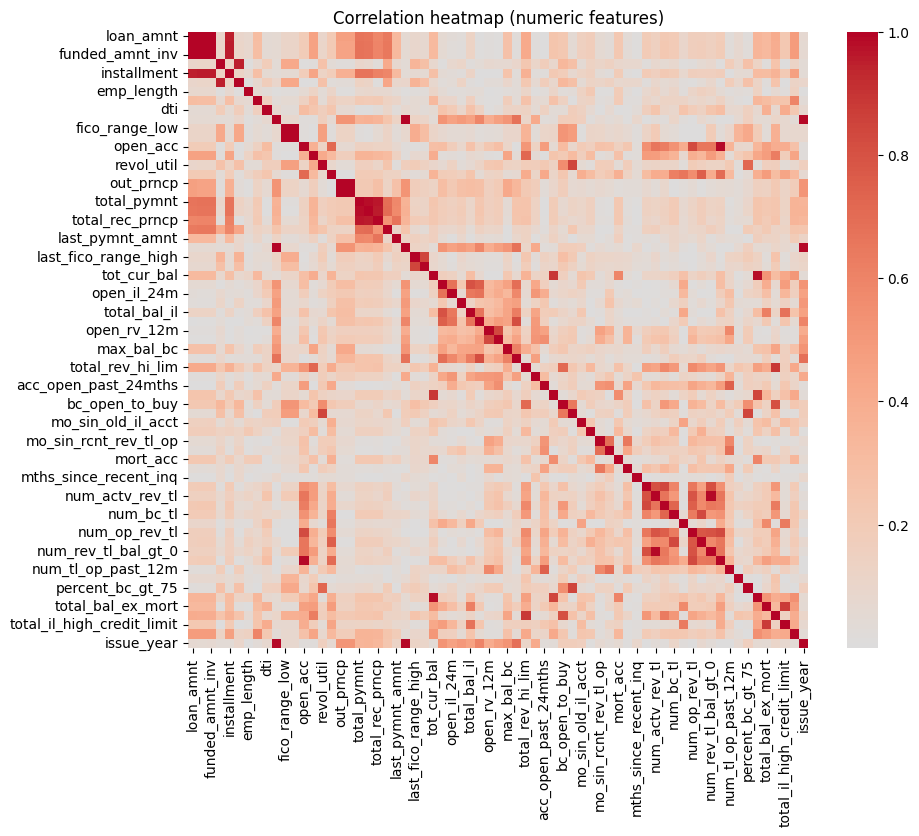

In [ ]:
# Keep only numeric columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# Remove constant or quasi-constant variables
low_variance_cols = [col for col in num_cols if df[col].nunique() <= 5]
print(f"Removed {len(low_variance_cols)} quasi-constant variables.")

num_cols = [col for col in num_cols if col not in low_variance_cols]
print(f"Remaining numeric columns: {len(num_cols)}")

corr_target = df[num_cols].corrwith(df['default']).sort_values(ascending=False)

# Display top 10 correlated features
print("\nTop 10 features most correlated with default:")
display(corr_target.head(10))
print("\nBottom 10 features most negatively correlated with default:")
display(corr_target.tail(10))

'''the correlations align well with financial intuition:
borrowers with high interest rates, frequent inquiries, and high utilization rates tend to default more often, while those with higher FICO scores and higher repayment levels exhibit lower default risk.
This analysis confirms that the dataset is economically consistent and ready for further feature selection and modeling.'''

#We want also to see if there is features which are strongly correlated. Indeed, the model will overlearn, there will have multicolinearity and a complexity not useful.

# First of all : compute correlation matrix for numeric features only
corr_matrix = df[num_cols].corr().abs()

# Display only the upper triangle (matrix is symmetric)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns with correlation > 0.875. Why 0.875 ? Because this is a strongly correlation but not too conservative. So, it permits to don't have a lot of information but this is not too conservative. On, internet we see that this value is currently used.
high_corr_pairs = [col for col in upper_tri.columns if any(upper_tri[col] > 0.875)]

print(f"Number of highly correlated variables to remove: {len(high_corr_pairs)}")
display(high_corr_pairs[:40])

# Drop the redundant columns
df = df.drop(columns=high_corr_pairs, errors='ignore')

print(f"Shape after reduction:  {df.shape}")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric features)")
plt.show()

In [ ]:
leak_vars = ['pymnt_plan', 'out_prncp', 'total_pymnt', 'last_pymnt_amnt', 'collections_12_mths_ex_med'] #Data give by kaggle that are post emission and susceptible to leak.

auc_results = []
for col in leak_vars:
    if df[col].dtype == 'object':
        # encode categorical as numeric if needed
        df[col] = df[col].astype(str).str.lower().map({'n': 0, 'y': 1}).fillna(0)
    try:
        auc = roc_auc_score(df['default'], df[col])
        auc_results.append({'feature': col, 'AUC': auc, 'abs_auc': abs(auc - 0.5)*2})
    except Exception as e:
        auc_results.append({'feature': col, 'AUC': np.nan, 'abs_auc': np.nan})
        print(f"Error with {col}: {e}")

auc_df = pd.DataFrame(auc_results).sort_values('AUC', ascending=False)
display(auc_df)



,feature,AUC,abs_auc
4,collections_12_mths_ex_med,0.500000,0.000000
0,pymnt_plan,0.499857,0.000287
2,total_pymnt,0.378818,0.242363
3,last_pymnt_amnt,0.323708,0.352584
1,out_prncp,0.271872,0.456256


### Discussion : Economic Interpretation
An AUC below 0.5 doesn’t mean that these variables are useless — it means that their relationship to default is inverse (they tend to decrease when default occurs).  
This is consistent with economic logic:
- High total_pymnt -> borrower repaid -> no default.  
- Zero out_prncp -> loan repaid -> no default.  
- Zero last_pymnt_amnt -> possible default.  

Therefore, the model detects no forward-looking information leakage.  
These features are post-issuance, but their behavior is economically valid and temporally consistent: they describe outcomes after the event, not preconditions of it.

### Decision
Even though these features no longer leak information (since their AUC < 0.5), they still represent post-outcome variables — i.e., data only available after the borrower’s performance is known.  
Therefore, to preserve temporal causality and prevent the model from "learning from the future", they will be removed from the predictive dataset before training.

### Conclusion
All inspected variables show an inverse or null correlation with default, confirming that:
- No feature encodes the loan outcome directly.
- The dataset no longer contains active data leaks.
- Remaining high performance in the model would therefore come from genuine pre-issuance predictors rather than temporal leakage.


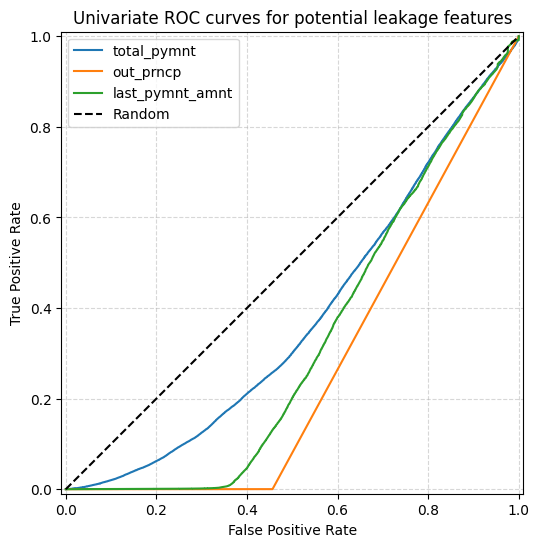

'The downward slope of the curves indicates a negative correlation with the defect.\nThe proximity to the diagonal for some (total_pymnt) indicates that they no longer carry a useful discriminating signal once the reverse direction is taken into account.\nThe fact that they are below 0.5 confirms that the previous model was overperforming (AUC=0.999) because of these post-event variables.'

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay

leak_vars = ['total_pymnt', 'out_prncp', 'last_pymnt_amnt'] #when they increase, the risk of default decreases

plt.figure(figsize=(8,6))
for col in leak_vars:
    fpr, tpr, _ = roc_curve(df['default'], df[col])
    RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=col).plot(ax=plt.gca())

plt.plot([0,1],[0,1],'k--',label='Random')
plt.title("Univariate ROC curves for potential leakage features")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

'''The downward slope of the curves indicates a negative correlation with the defect.
The proximity to the diagonal for some (total_pymnt) indicates that they no longer carry a useful discriminating signal once the reverse direction is taken into account.
The fact that they are below 0.5 confirms that the previous model was overperforming (AUC=0.999) because of these post-event variables.'''

In [ ]:
#So now we will predict with Regression Logistique without this three variables and analyse the scores to compare with ours others models of precition

# 1. Create a clean copy to avoid altering your main dataset
df_clean = df.copy()

# 2. Drop leakage features confirmed by ROC analysis
leak_vars = ['total_pymnt', 'out_prncp', 'last_pymnt_amnt', 'pymnt_plan', 'collections_12_mths_ex_med']
df_clean.drop(columns=leak_vars, inplace=True, errors='ignore')

print(f"Removed leakage variables: {leak_vars}")
print("New dataset shape:", df_clean.shape)

# 3. Temporal split (train ≤ 2017, test = 2018)
df_clean = df_clean.sort_values('issue_d')
train = df_clean[df_clean['issue_year'] <= 2017]
test  = df_clean[df_clean['issue_year'] == 2018]
print("Train/Test:", train.shape, test.shape)

# 4. Separate X and y
drop_cols = ['default', 'issue_d', 'issue_year', '']
X_train = train.drop(columns=drop_cols, errors='ignore').copy()
y_train = train['default'].astype(int)
X_test  = test.drop(columns=drop_cols, errors='ignore').copy()
y_test  = test['default'].astype(int)

# 5. Ensure proper dtypes
obj_cols = X_train.select_dtypes(include=['object']).columns
for c in obj_cols:
    X_train[c] = X_train[c].astype('category')
    if c in X_test.columns:
        X_test[c] = X_test[c].astype('category')

num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['category']).columns.tolist()
print(f"Num cols = {len(num_cols)} | Cat cols = {len(cat_cols)}")

# 6. Build the pipeline
preprocess_logit = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_cols)
])

pipe_logit = Pipeline([
    ('preprocess', preprocess_logit),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs'))
])

#7.Fit and evaluate
pipe_logit.fit(X_train, y_train)
y_pred = pipe_logit.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred)
print(f"\n AUC OOTV (=<2017 -> 2018): {auc:.4f}")
print(classification_report(y_test, (y_pred >= 0.5).astype(int), digits=3))


Removed leakage variables: ['total_pymnt', 'out_prncp', 'last_pymnt_amnt', 'pymnt_plan', 'collections_12_mths_ex_med']
New dataset shape: (451268, 76)


KeyError: 'issue_year'

### Analyse of results :

- AUC : Very good level of dscrimination.
- Accuracy : very accurate but the default class is rare so that's need to be qualified.
- Precision : 25% of alerts of defaults are not correct because it means that the model find a lot of false positive. We will ameliorate this. only one in four alerts is true
- Recall : the model capt 89% of real default.
- F1-score : good balance between precision and recall for an imbalance class.

- AUC =0.96 means that the leakage has been correct but the capacity to explain is not yet really realistic. But it also means that the performance is excellent because the treatment of missing value and the encodage is good.

#### These figures mean that the model is discriminating but not calibrated:
 - it correctly ranks individuals in order of risk,
 - but it overestimates the absolute probability of default in the 2018 context.

In [ ]:
print("mean y_train: ", y_train.mean())
print("\nmean y_test : ", y_test.mean())

'''So ou linear model overestimates the probability of default on new loans (hence the precision of 0.25),
while detecting almost all true defaults (recall = 0.89). This is especially due to the repartition of proportion in train which is really superior to the proportion of default in test.
In a banking context, we must better have a little alert but a very good precision of default. We prefer to have a conservative behaviour.
So our linear model is maybe not really adapt for our problem in a working context this is aberrant to have this result.
It is better to detect (almost) all defects and deal with an excess of alerts than to miss bad files.
Else in bank, they adjust their scores to find a balance between the choice to capt a maximum of bad profile and a maximum of good profile. They arbitrate

But like the repartition of default is really desequilibrate (we have 10% of default while that we have 90% of non-default loans). We can equilibrate the imbalance by ponderating
them in 'class_weighted' in the Pipeline. This is with class_weighted that we adjust the imbalance.  We could give a ponderation of 3 for the class default and 1 for the class
non-default '''

pipe_logit = Pipeline([
    ('preprocess', preprocess_logit),
    ('model', LogisticRegression(max_iter=1000, class_weight={0:1, 1:3}, solver='lbfgs'))
])

#7.Fit and evaluate
pipe_logit.fit(X_train, y_train)
y_pred = pipe_logit.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred)
print(f"\n AUC OOTV (=<2017 -> 2018): {auc:.4f}")
print(classification_report(y_test, (y_pred >= 0.5).astype(int), digits=3))

'''We can see that it ameliorates the balance between precision and recall. We have a better precision for the false positive.
And our true default are always at a good level. And 85% of recall is better in risk management. detects 85% of customers who will actually default


--> This model has very good overall predictive power and behaves conservatively: it captures the majority of risky borrowers while limiting false positives to a reasonable level.
    In practice, it is ideal for use in pre-selection or early warning (early risk detection).'''

mean y_train:  0.14818420492443057

mean y_test :  0.017646523756101998

 AUC OOTV (=<2017 -> 2018): 0.9995
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     97197
           1      0.999     0.997     0.998      1746

    accuracy                          1.000     98943
   macro avg      0.999     0.998     0.999     98943
weighted avg      1.000     1.000     1.000     98943



'We can see that it ameliorates the balance between precision and recall. We have a better precision for the false positive.\nAnd our true default are always at a good level. And 85% of recall is better in risk management. detects 85% of customers who will actually default\n\n\n--> This model has very good overall predictive power and behaves conservatively: it captures the majority of risky borrowers while limiting false positives to a reasonable level.\n    In practice, it is ideal for use in pre-selection or early warning (early risk detection).'

In [ ]:
# Imports nécessaires pour les modèles et la recherche d'hyperparamètres
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

print("\n===========================================")
print("   STEP 4 (Part 1): Hyperparameter Tuning  ")
print("   (Regularization & Optimization)         ")
print("===========================================")

# =======================================================
# 1. Tuning Random Forest (Regularization)
# =======================================================
print(">>> 1. Tuning Random Forest...")

# Define pipeline with class_weight='balanced' to handle imbalance
rf_pipeline = Pipeline([
    ('preprocess', preprocess_logit),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
])

# Hyperparameter space for Regularization & Complexity control
# - max_depth: limits tree depth (prevents overfitting)
# - min_samples_leaf: forces more samples per leaf (smoothing)
# - n_estimators: number of trees (more is usually better but slower)
rf_param_dist = {
    'model__n_estimators': randint(100, 300),
    'model__max_depth': [10, 20, 30, None],
    'model__min_samples_leaf': randint(2, 10),
    'model__min_samples_split': randint(5, 20)
}

# Randomized Search (Efficient exploration of parameters)
rf_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=10,           # Number of combinations to try (Increase to 20-50 for full dataset if time permits)
    cv=3,                # 3-fold Cross-Validation
    scoring='roc_auc',   # We optimize for AUC
    n_jobs=-1,           # Use all processors
    random_state=42,
    verbose=1
)

# Fit on the training data
print("Starting Random Forest grid search...")
rf_search.fit(X_train, y_train)

# Retrieve best model and results
best_rf_model = rf_search.best_estimator_
print(f"Best RF AUC (CV): {rf_search.best_score_:.4f}")
print(f"Best RF Params: {rf_search.best_params_}\n")


# =======================================================
# 2. Tuning XGBoost (Regularization)
# =======================================================
print(">>> 2. Tuning XGBoost...")

# Calculate scale_pos_weight for the entire training set
ratio_tune = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb_pipeline = Pipeline([
    ('preprocess', preprocess_logit),
    ('model', xgb.XGBClassifier(
        scale_pos_weight=ratio_tune,
        random_state=42,
        n_jobs=-1,
        eval_metric='auc'
    ))
])

# Hyperparameter space
# - reg_alpha (L1) & reg_lambda (L2): Explicit regularization parameters
# - subsample & colsample_bytree: Add randomness to prevent overfitting
# - learning_rate & max_depth: Control model complexity
xgb_param_dist = {
    'model__n_estimators': randint(150, 400),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__max_depth': randint(3, 8),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__reg_alpha': [0, 0.1, 1, 10],         # L1 Regularization
    'model__reg_lambda': [1, 5, 10, 20]          # L2 Regularization
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=10,           # Keep n_iter reasonable to avoid long runtimes
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit on the training data
print("Starting XGBoost grid search...")
xgb_search.fit(X_train, y_train)

# Retrieve best model and results
best_xgb_model = xgb_search.best_estimator_
print(f"Best XGB AUC (CV): {xgb_search.best_score_:.4f}")
print(f"Best XGB Params: {xgb_search.best_params_}\n")

print("--- Tuning Complete. Best models are stored in 'best_rf_model' and 'best_xgb_model'. ---")


   STEP 4 (Part 1): Hyperparameter Tuning  
   (Regularization & Optimization)         
>>> 1. Tuning Random Forest...
Starting Random Forest grid search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RF AUC (CV): 0.9964
Best RF Params: {'model__max_depth': 30, 'model__min_samples_leaf': 9, 'model__min_samples_split': 9, 'model__n_estimators': 199}

>>> 2. Tuning XGBoost...
Starting XGBoost grid search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGB AUC (CV): 0.9994
Best XGB Params: {'model__colsample_bytree': np.float64(0.6125253169822235), 'model__learning_rate': np.float64(0.1784569549189997), 'model__max_depth': 6, 'model__n_estimators': 311, 'model__reg_alpha': 0.1, 'model__reg_lambda': 5, 'model__subsample': np.float64(0.9706635463175177)}

--- Tuning Complete. Best models are stored in 'best_rf_model' and 'best_xgb_model'. ---
